In [1]:
## Standard libraries
import os
import numpy as np
import pandas as pd
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# ## tqdm for loading bars
# from tqdm.notebook import tqdm

# for one-hot encoding
from keras.utils.np_utils import to_categorical   

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import default_collate
import torch.optim as optim

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/simple_transformer"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)



/tmp/ipykernel_2814883/1565007497.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
2024-11-12 10:21:24.153274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 10:21:24.220408: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 10:21:24.239505: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable

Device: cuda:0


In [2]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [4]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor


In [ ]:
def pad_group_with_zeros(group, target_rows):
    # Calculate the number of rows to add
    num_missing_rows = target_rows - len(group)
    if num_missing_rows > 0:
        # Create a DataFrame with the required number of padding rows
        # input padding
        zero_rows = pd.DataFrame(0.3333, index=range(num_missing_rows), columns=group.columns)
        # Label padding
        zero_rows.iloc[:, 0] = 31
        # Concatenate the group with the zero rows
        group = pd.concat([group, zero_rows], ignore_index=True)
    return group


In [5]:
class ToTensor(object):
    """Convert Series in sample to Tensors."""

    def __call__(self, sample):
        trial, label = sample['trial'], sample['label']
        trial = torch.from_numpy(trial).float()
        label = torch.from_numpy(label).float()
        return trial, label


In [6]:
def plot_attention_maps(input_data, attn_maps, labels, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = attn_maps[idx].detach().cpu().numpy()
    labels = labels[idx]
    labels = [int(x) for x in labels] 

   # num_heads = attn_maps[0].shape[0]
    num_heads = 1
    # num_layers = len(attn_maps)
    num_layers = 1
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps, origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(labels)
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(labels)
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()


#### Global settings

In [7]:
NUM_FIX = 30 
BATCH_SIZE = 64
NUM_CLASSES = 31


## Contents 
   * [Preparing the data](#Eye-tracking-data-set)
   * [Training the model using LightningModule](#Using-LightningModule)
   * [Training the model using standard PyTorch](#Without-LightningModule) 
   * [Problem with the MarginRankingLoss function](#Exploring-MarginRankingLoss)
   * [Trying out CrossEntropyLoss](#Trying-CategoricalCrossEntropy-loss)

## Eye-tracking data set

In [83]:
class FixationsOrder(Dataset):
    """Dataset with the long-format sequence of fixations made during reading by dyslexic 
    and normally-developing Russian-speaking monolingual children."""

    def __init__(self, csv_file, transform=None, target_transform = None, 
                 n_fix = NUM_FIX, 
                 dropPhonologyFeatures = True, dropPhonologySubjects = True):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_transform (callable, optional): Optional transform to be applied
                on a label.
        """
        self.fixations_frame = pd.read_csv(csv_file)
        
        # remove demography and identification
        self.fixations_frame = self.fixations_frame.drop(columns = ['group', 'fix_x', 
                                                                    'fix_y', 'IQ', 'sex',
                                                                    'Grade', 'Age',
                                                                    'Sound_detection',
                                                                    'Sound_change',
                                                                    'Reading_speed'
                                                                    ]) 
        
        # log-transforming frequency
        to_transform = ['frequency', 'predictability', 'fix_dur'] 
        for column in to_transform:
            self.fixations_frame[column] = self.fixations_frame[column].apply(lambda x: np.log(x) if x > 0 else 0) 

        # center 
        cols = ['fix_dur', 'landing', 'predictability',
                'frequency', 'word_length', 'number.morphemes', 
                'next_fix_dist', 'sac_ampl', 'sac_angle', 
                'sac_vel']
        for col in cols:
            self.fixations_frame[col] = np.where(self.fixations_frame[col] == 0, -4,
                (self.fixations_frame[col] - self.fixations_frame[col].mean())/self.fixations_frame[col].std(ddof=0)) 
        

        # drop padding 
        self.fixations_frame = self.fixations_frame[self.fixations_frame['fix_dur'] != -4]
        
        
        # converting direction to a dummy-coded variable
        self.fixations_frame['direction'] = np.where(self.fixations_frame['direction'].isnull(), 0,
                                                     self.fixations_frame['direction'])
        self.fixations_frame = pd.concat([self.fixations_frame, 
                                          pd.get_dummies(self.fixations_frame['direction'], 
                                                         prefix='dummy')], axis=1)
        
        # exceptions: columns where 0 is meaningful and should not be counted as NA
        cols = ['rel.position', 'dummy_DOWN', 'dummy_LEFT','dummy_RIGHT', 'dummy_UP']
        for col in cols:
            self.fixations_frame[col] = (self.fixations_frame[col] - \
                                             self.fixations_frame[col].mean())/self.fixations_frame[col].std(ddof=0)
            
        if dropPhonologySubjects == True:
            # Drop subjects
            self.fixations_frame.dropna(axis = 0, how = 'any', inplace = True)
        else:
            # Drop columns
            self.fixations_frame.dropna(axis = 1, how = 'any', inplace = True)
        
        
        self.fixations_frame['subj'] = self.fixations_frame['subj'].astype(str)
        self.fixations_frame['item'] = self.fixations_frame['item'].astype(str)
        self.fixations_frame['Combined'] = self.fixations_frame[['subj', 'item']].agg('_'.join, axis=1)
        
        # cleaning up
        self.fixations_frame.drop(columns = ['subj', 'item', 'direction', 'dummy_0'], inplace = True)

        new_data = pd.DataFrame([])

        for i in range(2):
            scrambled = self.fixations_frame.groupby(['Combined']).sample(frac = 1)
            padded = scrambled.groupby('Combined', group_keys=False).apply(lambda x: 
                                                                           pad_group_with_zeros(x, NUM_FIX))
            new_data = pd.concat([new_data, padded], axis = 0)
        new_data.drop(columns = "Combined", inplace = True)
    
        
        #### Fixation index is the label
        self.fixations_frame = new_data.to_numpy()
        dataReshaped = np.reshape(self.fixations_frame, (int(len(self.fixations_frame)/n_fix), 
                                                         n_fix, self.fixations_frame.shape[1]))

        self.predictors = dataReshaped[:,:,1:]
        self.labels = dataReshaped[:,:,0]
        self.labels = to_categorical(self.labels-1, num_classes=NUM_CLASSES)   # one-hot encoding

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        trial = self.predictors[idx]
        label = self.labels[idx]
        
        sample = {'trial': trial, 'label': label}

        if self.transform:
            sample = self.transform(sample)
            
        if self.target_transform:
            sample = self.target_transform(sample)
            
        return sample


In [84]:
transformed_dataset = FixationsOrder(csv_file='data/fixation_reading_speed_sentence.csv', 
                                    transform=ToTensor(),
                                    dropPhonologySubjects = True)

train_size = int(0.8 * len(transformed_dataset))
val_size = int(0.1 * len(transformed_dataset))
test_size = len(transformed_dataset) - val_size - train_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [85]:
trials, labels = next(iter(train_loader))

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 30, 15])
Labels batch shape: torch.Size([64, 30, 31])


In [99]:
# Checking how attention mask would work
torch.eq(trials, 0.3333).any(dim=2)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='cuda:0')

## Transformer

### Using LightningModule

In [86]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model = self.hparams.model_dim)
        self.transformer = nn.MultiheadAttention(embed_dim = self.hparams.input_dim,  
                                                 num_heads = self.hparams.num_heads, 
                                                 dropout = self.hparams.dropout, 
                                                 bias = False,
                                                 batch_first = True)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x, add_positional_encoding=False):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        attention_mask = torch.eq(x, 0.3333).any(dim=2)
        
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x, weights = self.transformer(x, key = x, value = x, key_padding_mask = attention_mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, add_positional_encoding=False):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_mask = torch.eq(x, 0.3333).any(dim=2)

        if add_positional_encoding:
            x = self.positional_encoding(x)
        x, weights = self.transformer(x, key = x, value = x, key_padding_mask = attention_mask)
        return weights

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError


In [88]:
class PositionPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, n_fix = NUM_FIX, mode="train"):
        # Fetch data and transform labels, add targets
        inp_data, labels = batch
        target = torch.ones([len(labels), n_fix, NUM_CLASSES]).to(device)  
        myloss = nn.MarginRankingLoss()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=False)
        loss = myloss(labels,   # true labels
                      preds,    # predictions
                      target)   # true labels are weighted higher
        acc = (preds.argmax(dim=-1) == labels.argmax(dim=-1)).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [89]:
def train_position(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "PositionTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True,
                                                    monitor="val_loss", 
                                                    mode='min')],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs = 15,
                         gradient_clip_val=0.5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

#     # Check whether pretrained model exists. If yes, load it and skip training
#     pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
#     if os.path.isfile(pretrained_filename):
#         print("Found pretrained model, loading...")
#         model = PositionPredictor.load_from_checkpoint(pretrained_filename)
#     else:
    model = PositionPredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
    trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], 
              "val_acc": val_result[0]["test_acc"],
              "test_loss": test_result[0]["test_loss"],
              "val_loss": val_result[0]["test_loss"]
             }

    model = model.to(device)
    return model, result

In [90]:
reverse_model, reverse_result = train_position(input_dim=15,
                                              model_dim=12,
                                              num_heads=1,
                                              num_classes=NUM_CLASSES,
                                              num_layers=1,
                                              dropout=0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | positional_encoding | PositionalEncoding | 0      | train
1 | transformer         | MultiheadAttention | 900    | train
2 | output_net          | Sequential         | 1.1 K  | train
-------------------------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/annlaurin/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/annlaurin/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/annlaurin/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: |                                                | 0/? [00:00<?, ?it/s]

In [91]:
print(f"Validation accuracy: {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 *reverse_result['test_acc']):4.2f}%")

Validation accuracy: 39.15%
Test accuracy: 38.02%


In [92]:
print(f"Validation loss: {(reverse_result['val_loss']):4.4f}")
print(f"Test loss: {(reverse_result['test_loss']):4.4f}")

Validation loss: 0.0196
Test loss: 0.0200


#### Checking accuracy by hand - not a mistake, really 40%

In [96]:
data_input, labels = next(iter(test_loader))
preds = reverse_model(data_input)
preds.argmax(dim=-1)[0]

tensor([ 1,  1,  1, 30,  1,  1,  1,  1,  1,  1, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], device='cuda:0')

In [97]:
(preds.argmax(dim=-1) == labels.argmax(dim=-1)).float().mean()

tensor(0.3943, device='cuda:0')

In [98]:
correct = (preds.argmax(dim=-1) == labels.argmax(dim=-1)).float().sum()
total = list(labels.argmax(dim=-1).shape)[0]*list(labels.argmax(dim=-1).shape)[1]
correct/total

tensor(0.3943, device='cuda:0')

#### Attention map

In [20]:
data_input, labels = next(iter(val_loader))

inp_data = data_input.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)
labels = labels.argmax(dim=-1)

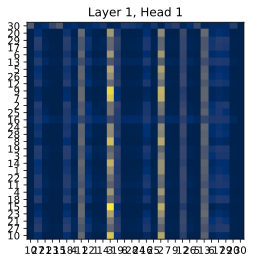

In [21]:
plot_attention_maps(data_input, attention_maps, labels, idx=2)

### Without LightningModule

In [22]:
class FixationOrder(nn.Module):
    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, 
                dropout=0.0, input_dropout=0.0):
        super().__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.dropout = dropout
        self.input_dropout = input_dropout
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.transformer = nn.MultiheadAttention(embed_dim = self.input_dim,  
                                                 num_heads = self.num_heads, 
                                                 dropout = self.dropout, 
                                                 bias = False,
                                                 batch_first = True)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.input_dim, self.model_dim), 
            nn.Linear(self.model_dim, self.num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.mask = torch.eq(x, 0.3333).any(dim=2)
        x, weights = self.transformer(x, key = x, value = x, key_padding_mask = self.mask)
        x = self.output_net(x)
        return x

In [23]:
### Instantiate the model
model_1 = PositionPredictor(input_dim=15,  
                            model_dim=12,
                            num_heads=1,
                            num_classes=NUM_CLASSES,
                            num_layers=1,
                            dropout=0.0,
                            lr=5e-3,
                            warmup=50,
                            max_iters = 10*len(train_loader)
                           ).to(device)
print(model_1)


# model_1 = FixationOrder(input_dim=15,  
#                           model_dim=12,
#                           num_heads=1,
#                           num_classes=NUM_CLASSES,
#                           num_layers=1,
#                           dropout=0.0,
#                        ).to(device)
# print(model_1)

# Setup loss function
loss_fn = nn.MarginRankingLoss() 

# Setup optimizer to optimize model's parameters
optimizer = optim.Adam(model_1.parameters(), lr= 5e-2)

PositionPredictor(
  (positional_encoding): PositionalEncoding()
  (transformer): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=15, out_features=15, bias=False)
  )
  (output_net): Sequential(
    (0): Linear(in_features=15, out_features=12, bias=True)
    (1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=12, out_features=31, bias=True)
    (5): Softmax(dim=-1)
  )
)


In [24]:
epochs = 5

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    train_acc = 0
    denominator_train = 0
    
    ### Training
    model_1.train()
    
    for X_train, y_train in train_loader:
        # 1. Forward pass (model outputs raw logits)
        
        y_pred = model_1(X_train) 
        
        # 2. Calculate loss/accuracy
        train_target = torch.ones([len(y_train), NUM_FIX, NUM_CLASSES]).to(device)  # first input is the labels
        tloss = loss_fn(y_pred, y_train,
                       train_target
                       ) 
        
        train_correct += (y_pred.argmax(dim=-1) == y_train.argmax(dim=-1)).float().sum().item()
        denominator_train += list(y_train.argmax(dim=-1).shape)[0]*list(y_train.argmax(dim=-1).shape)[1] # how many slots to predict
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        tloss.backward()
 
        # 5. Optimizer step
        optimizer.step()
        
        train_loss += tloss.item() * X_train.size(0)
        
    train_loss /= len(train_loader.dataset)
    train_acc = 100.0 * train_correct / denominator_train # len(train_loader.dataset)

    test_loss = 0.0
    test_correct = 0
    test_acc = 0
    denominator = 0
    
    model_1.eval()
    
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred_test = model_1(X_test) 
            
            test_target = torch.ones([len(y_test), NUM_FIX, NUM_CLASSES]).to(device)  # first input is the labels
            loss = loss_fn(y_pred_test, y_test,
                           test_target
                          ) 

            test_loss += loss.item() * X_test.size(0)

            denominator += list(y_test.argmax(dim=-1).shape)[0]*list(y_test.argmax(dim=-1).shape)[1]
            test_correct += (y_pred_test.argmax(dim=-1) == y_test.argmax(dim=-1)).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100.0 * test_correct / denominator # len(test_loader.dataset)

    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'Epoch {epoch+1}: Train Accuracy: {train_acc:.4f}%, Test Accuracy: {test_acc:.4f}%')


Epoch 1: Train Loss: 0.0205, Test Loss: 0.0200
Epoch 1: Train Accuracy: 37.2010%, Test Accuracy: 38.0674%
Epoch 2: Train Loss: 0.0201, Test Loss: 0.0198
Epoch 2: Train Accuracy: 37.6398%, Test Accuracy: 38.7602%
Epoch 3: Train Loss: 0.0199, Test Loss: 0.0197
Epoch 3: Train Accuracy: 38.2943%, Test Accuracy: 38.9211%
Epoch 4: Train Loss: 0.0199, Test Loss: 0.0198
Epoch 4: Train Accuracy: 38.3418%, Test Accuracy: 38.7173%
Epoch 5: Train Loss: 0.0199, Test Loss: 0.0197
Epoch 5: Train Accuracy: 38.4037%, Test Accuracy: 39.0305%


In [70]:
X_test, y_test = next(iter(test_loader))
y_pred_test = model_1(X_test)
predictions = y_pred_test.argmax(dim=-1)
predictions[0]

tensor([ 1,  1,  1,  1,  1,  1,  1, 30, 30,  1,  1,  1,  1, 30,  1,  1,  1,  1,
         1,  1,  1, 30,  1,  1, 30,  1,  1, 30, 30, 30], device='cuda:0')

### Exploring MarginRankingLoss

Something is wrong here, loss should not be the same when the order of the first two arguments changes.

In [72]:
loss_fn = nn.MarginRankingLoss()
loss_fn(y_pred_test[0,0], y_test[0,0], test_target[0,0]) == \
    loss_fn(y_test[0,0], y_pred_test[0,0], test_target[0,0]) 

tensor(True, device='cuda:0')

The same problem for one-hot encoded-like tensors:

In [73]:
loss_fn(torch.tensor([0.,1., 0.]), torch.tensor([0., 0.,1.]), torch.tensor([1.,1.,1.])) == \
    loss_fn(torch.tensor([0., 0.,1.]),  torch.tensor([0.,1., 0.]),  torch.tensor([1.,1.,1.]))

tensor(True)

In [74]:
input1 = torch.tensor([[1.,0.,0.,0.],
                       [0.,1.,0.,0.],
                       [1.,0.,0.,0.],
                       [0.,1.,0.,0.]], requires_grad=True)

input2 = torch.tensor([[0.,0.,1.,0.],
                       [0.,0.,1.,0.],
                       [0.,0.,0.,1.],
                       [0.,0.,0.,1.]], requires_grad=True)
target = torch.ones([4, 4], requires_grad=True)

loss_fn(input1, input2, target) == loss_fn(input2, input1, target)

tensor(True)

Works as expected for not one-hot encoded vectors:

In [77]:
loss_fn(torch.tensor([0.]), torch.tensor([1.]), torch.tensor([1.])) == \
    loss_fn(torch.tensor([1.]), torch.tensor([0.]),  torch.tensor([1.]))

tensor(False)

In [78]:
loss_fn(torch.tensor([0., 1., 2.]), torch.tensor([1.,3., 5.]), torch.tensor([1.,1.,1.])) == \
    loss_fn(torch.tensor([1.,3., 5.]), torch.tensor([0., 1., 2.]),  torch.tensor([1.,1.,1.]))

tensor(False)

### Trying CategoricalCrossEntropy loss

Not a good alternative: If trained long enough, this model just predicts the padding label and no other labels at all.

In [35]:
class FixationOrder(nn.Module):
    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.dropout = dropout
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.transformer = nn.MultiheadAttention(embed_dim = self.input_dim,
                                                 num_heads = self.num_heads, 
                                                 dropout = self.dropout, 
                                                 bias = False,
                                                 batch_first = True)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.input_dim, self.model_dim), 
            nn.Linear(self.model_dim, self.num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.mask = torch.eq(x, 0.3333).any(dim=2)
        x0, weights = self.transformer(x, key = x, value = x, key_padding_mask = self.mask) 
        x1 = self.output_net(x0)
        return x1

In [36]:
### Instantiate the model
model_test = FixationOrder(input_dim=15,  
                          model_dim=12,
                          num_heads=1,
                          num_classes=NUM_CLASSES,
                          num_layers=1,
                          dropout=0.0,
                       ).to(device)
print(model_test)
# Setup loss function
loss_fn = nn.CrossEntropyLoss()  

# Setup optimizer to optimize model's parameters
optimizer = optim.Adam(model_test.parameters(), lr= 5e-4)

FixationOrder(
  (transformer): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=15, out_features=15, bias=False)
  )
  (output_net): Sequential(
    (0): Linear(in_features=15, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=31, bias=True)
  )
)


In [37]:
epochs = 61

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    train_acc = 0
    denominator_train = 0
    
    ### Training
    model_test.train()
    
    for X_train, y_train in train_loader:
        # 1. Forward pass (model outputs raw logits)
        y_pred = model_test(X_train) 
        
        # 2. Calculate loss/accuracy
        tloss = loss_fn(y_pred, y_train)
        
        m = nn.Softmax(dim=-1)
        y_pred = m(y_pred)
        train_correct += (y_pred.argmax(dim=-1) == y_train.argmax(dim=-1)).float().sum().item()
        denominator_train += y_train.argmax(dim=-1).size(0)*y_train.argmax(dim=-1).size(1) # how many slots to predict
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        tloss.backward()
 
        # 5. Optimizer step
        optimizer.step()
        
        train_loss += tloss.item() * X_train.size(0)
        
    train_loss /= len(train_loader.dataset)
    train_acc = 100.0 * train_correct / denominator_train # len(train_loader.dataset)

    test_loss = 0.0
    test_correct = 0
    test_acc = 0
    denominator = 0
    
    model_test.eval()
    
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred_test = model_test(X_test) 
            loss = loss_fn(y_pred_test, y_test) 
            test_loss += loss.item() * X_test.size(0)

            y_pred_test = m(y_pred_test)
            denominator += y_test.argmax(dim=-1).size(0)*y_test.argmax(dim=-1).size(1)
            test_correct += (y_pred_test.argmax(dim=-1) == y_test.argmax(dim=-1)).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100.0 * test_correct / denominator 

    if epoch % 20 == 0:
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'Epoch {epoch+1}: Train Accuracy: {train_acc:.4f}%, Test Accuracy: {test_acc:.4f}%')


Epoch 1: Train Loss: 3.1680, Test Loss: 3.0092
Epoch 1: Train Accuracy: 9.0475%, Test Accuracy: 15.2424%
Epoch 21: Train Loss: 2.6943, Test Loss: 2.6913
Epoch 21: Train Accuracy: 29.7508%, Test Accuracy: 30.2317%
Epoch 41: Train Loss: 2.6685, Test Loss: 2.6664
Epoch 41: Train Accuracy: 36.2748%, Test Accuracy: 37.1900%
Epoch 61: Train Loss: 2.6551, Test Loss: 2.6546
Epoch 61: Train Accuracy: 35.7386%, Test Accuracy: 36.3985%


In [40]:
X_test, y_test = next(iter(test_loader))
y_pred_test = model_test(X_test)

y_pred_test = m(y_pred_test)
y_pred_test.argmax(dim=-1)[0]

tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], device='cuda:0')